In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements
from skimage.morphology import label
from matplotlib.patches import Rectangle

from z3 import *
from IPython.display import Markdown, display,Image,HTML

### Puzzle as published 
https://www.janestreet.com/puzzles/twenty-four-seven-four-in-one-index/

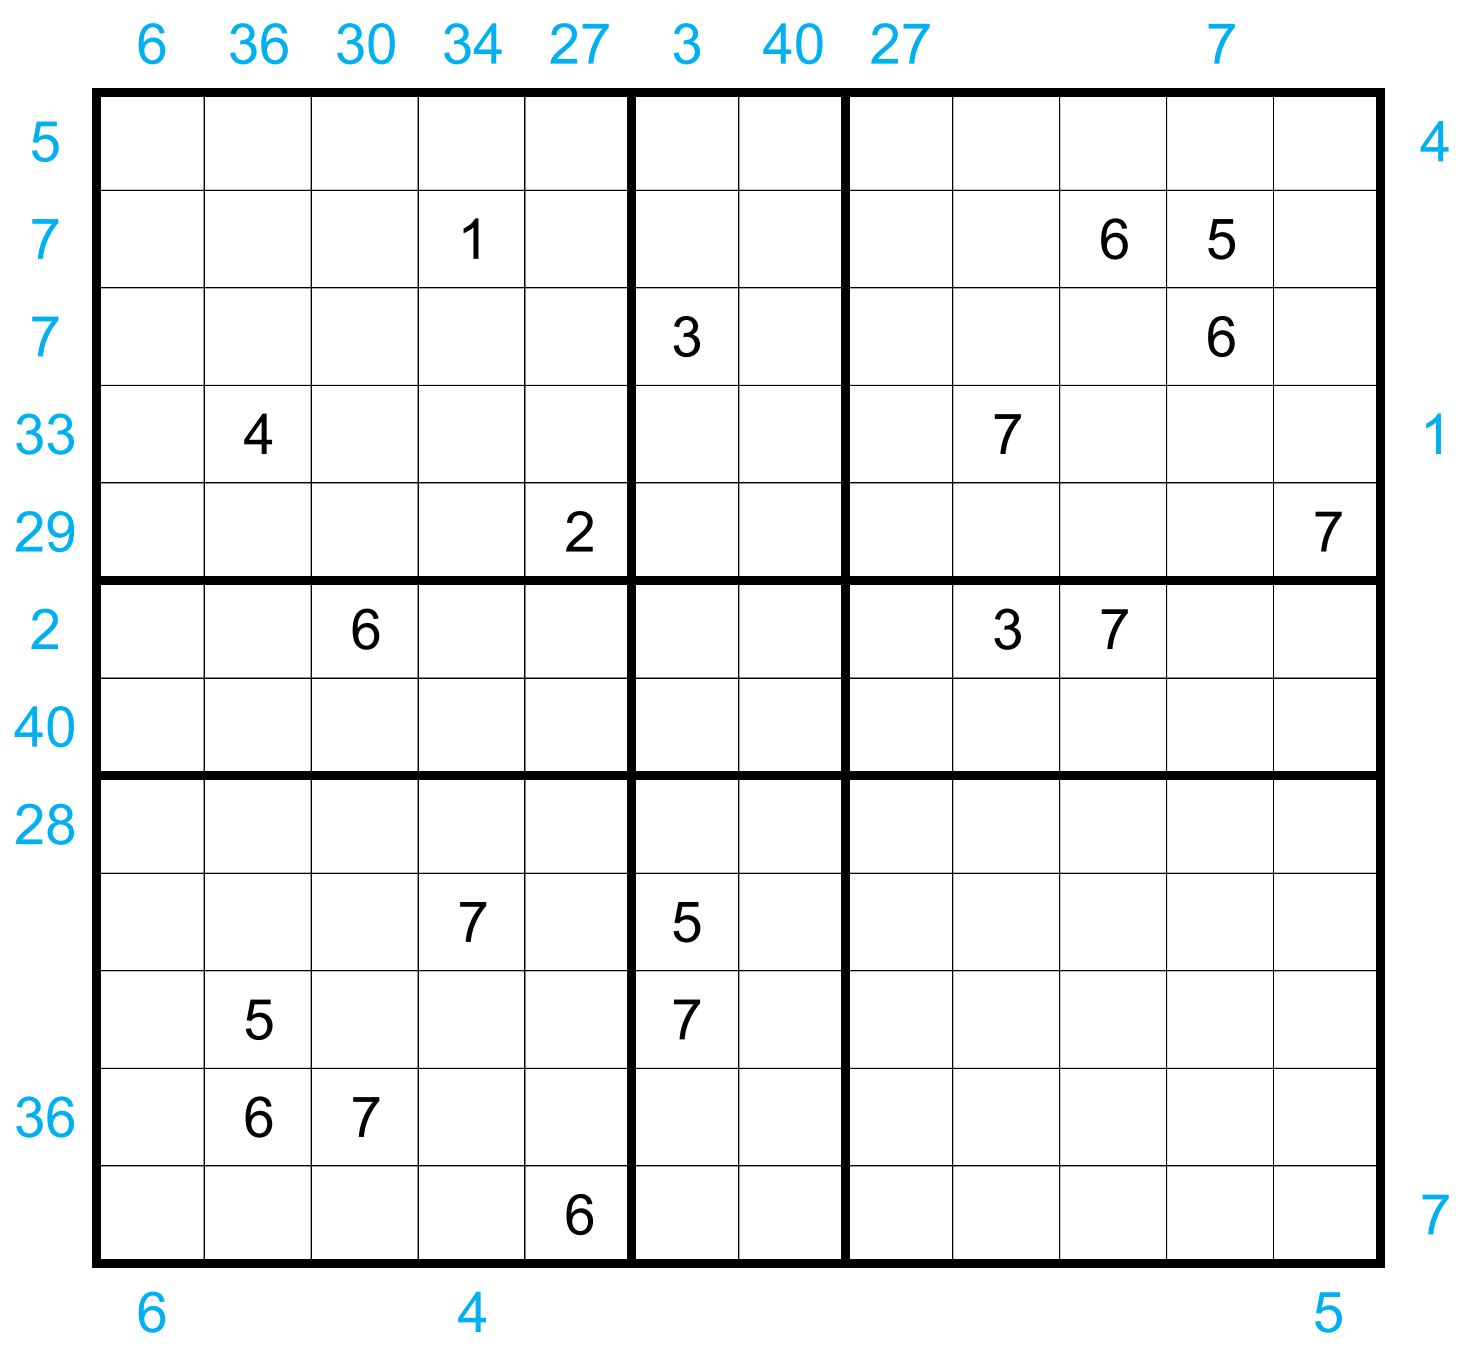

In [2]:
#pull in the puzzle
url='https://www.janestreet.com/puzzles/twenty-four-seven-four-in-one-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
tags=soup.findAll('img')
for match in tags:
    match.decompose()

display(Markdown('### Puzzle as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/20230201_twenty_four_seven.PNG',width=300))
HTML(str(soup.find_all('div', {'class' :'col-12'})[0])+str(soup.find_all('div', {'class' :'col-12'})[4]))

In [3]:
# Set up the grids to be solved 
grid =np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 5, 0],
                [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0],
                [0, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
                [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 7],
                [0, 0, 6, 0, 0, 0, 0, 0, 3, 7, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 7, 0, 5, 0, 0, 0, 0, 0, 0],
                [0, 5, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0],
                [0, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0]])

top_looks = [6,36,30,34,27, 3,40,27, 0, 0, 7, 0]
bot_looks = [6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5]
lft_looks = [5, 7, 7,33,29, 2,40,28, 0, 0,36, 0]
rgt_looks = [4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 7]

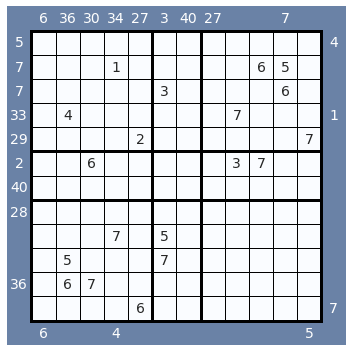

Sum cols : [ 0 15 13  8  8 15  0  0 10 13 11  7]
Sum rows : [ 0 12  9 11  9 16  0  0 12 12 13  6]


In [4]:
def grid_print(numbers,a,b,c,d):
    '''print the grid and the blue numbers'''
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    out= np.zeros((14,14),dtype=int)

    out[1:13,1:13]=numbers
    out[0,1:13]=a
    out[1:13,0]=b
    out[13,1:13]=c
    out[1:13,13]=d
  
    x = np.array((out).astype('int').astype('str'))
    x[x=="0"] =""
    y =np.ones((14,14))
    y[1:13,1:13]=0
    ax = sns.heatmap(y,annot=x,cbar=False,cmap="Blues",fmt="",linecolor='w',alpha = .6,annot_kws={"fontsize":14})
    ax.add_patch(Rectangle((1,1),12,12, fill=False, edgecolor='k', lw=3))
    ax.add_patch(Rectangle((1,1), 7, 7, fill=False, edgecolor='k', lw=3))
    ax.add_patch(Rectangle((6,1), 7, 7, fill=False, edgecolor='k', lw=3))
    ax.add_patch(Rectangle((1,6), 7, 7, fill=False, edgecolor='k', lw=3))
    ax.add_patch(Rectangle((6,6), 7, 7, fill=False, edgecolor='k', lw=3))
    for i in range(1,13):
        for j in range(1,13):
            ax.add_patch(Rectangle((i,j), 1, 1, fill=False, edgecolor='k', lw=1))
    
    ax.axis("off")

    plt.tight_layout()
    plt.show()
    print("Sum cols :",np.sum(numbers,axis=0))
    print("Sum rows :",np.sum(numbers,axis=1))
    
grid_print(grid,top_looks,lft_looks,bot_looks,rgt_looks)

In [5]:
def neighbours(i,j,N):
    '''Return orthogonal neighbours'''
    return [[i+x,j+y] for (x,y) in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >= 0 and i+x < N and j+y >= 0 and j+y < N ]

def subgrid(nums,g):
    '''set 24-7 contstraints for a subgrid'''
    #normal 24-7  constraints 
    #4 nums sum to 20 for each row + col
    for n in range(7):
        g += Sum([n for n in nums[:,n]]) == 20
        g += Sum([n for n in nums[n,:]]) == 20

        g += PbEq([(nums[n,j] !=0,1) for j in range(7)],4) 
        g += PbEq([(nums[i,n] !=0,1) for i in range(7)],4) 
        
    # 1 one,2 twos etc   
    for n in range(1,8):
        g += PbEq([(e == n,1) for (i,j),e in np.ndenumerate(nums)],n)

def looks(nums,param,g):
    '''set contstraints for a look'''
    # either first num or sum
    if param == 0:
        next
    else:
        g+=Or(If(nums[0] == 0,
                     If(nums[1] == 0,
                         If(nums[2] == 0,
                            nums[3] == int(param),
                         nums[2] == int(param)),
                      nums[1] == int(param)),
                    nums[0] == int(param)),
              Sum([i for i in nums]) == int(param))
        
def areas(grid):
    '''Get the products of the areas of the connected cells'''
    labels, num = measurements.label(grid==0)
    areas = measurements.sum(grid==0, labels, index=range(1, num+1))
    return np.prod(areas)


Took 0.4009 seconds


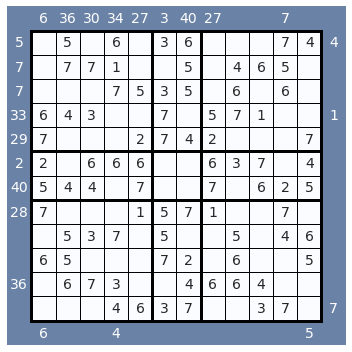

Sum cols : [33 36 30 34 27 40 40 27 37 27 38 31]
Sum rows : [31 35 32 33 29 40 40 28 35 31 36 30]
Answer is : 74,649,600
Connectivity : True


In [6]:
start = time.time()
N = 12

# Variables and solver
X = np.array(IntVector("x",N*N),dtype=object).reshape((N,N))
s = Tactic('smt').solver()

# Set limits and fixed cells
s += [e == int(grid[i,j]) for (i,j),e in np.ndenumerate(X) if grid[i,j]!=0]
s += [And(e>=0,e<=7) for _,e in np.ndenumerate(X)]

# subgrid 24-7 constraints
subgrid(X[:7,:7],s)
subgrid(X[5:,:7],s)
subgrid(X[:7,5:],s)
subgrid(X[5:,5:],s)

# the blue numbers
for i,e in enumerate(top_looks):
    looks(X[:,i],e,s)
for i,e in enumerate(lft_looks):
    looks(X[i,:],e,s)
for i,e in enumerate(bot_looks):
    looks(X[::-1,i],e,s)
for i,e in enumerate(rgt_looks):
    looks(X[i,::-1],e,s)
    
#no 2x2 and all have neighbour to help connectivity  
s += [Or(X[i,j] ==0,X[i+1,j] ==0,X[i,j+1] ==0,X[i+1,j+1] ==0) for j in range(N-1) for i in range(N-1)]

s += [Implies(X[i,j] !=0,Or([X[k,l] !=0 for (k,l) in neighbours(i,j,N)])) for j in range(N) for i in range(N) ] 
    
# loop through solutions until we find a connected one
while s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        result =  evalu(X)
        if np.max(label(result != 0,connectivity=1)) == 1 :
            print('Took {:0.4f} seconds'.format(time.time()-start))
            grid_print(result,top_looks,lft_looks,bot_looks,rgt_looks)
            print("Answer is : {:,.0f}".format(areas(result)))
            print("Connectivity :",np.max(label(result != 0,connectivity=1)) == 1 )
        s+= Or([X[i,j] != int(e) for (i,j),e in np.ndenumerate(result)])

In [7]:

def sub_print(numbers):
    '''Function to check the subgrids'''
    fig,ax = plt.subplots(1,1,figsize=(2,2))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] =""
    ax = sns.heatmap(np.zeros((7,7)),annot=x,cbar=False,cmap="Greys",fmt="",linecolor='k',linewidth=2,annot_kws={"fontsize":10})

    ax.axis("off")
    plt.xticks(rotation=0,fontsize =12)
    plt.yticks(rotation=0,fontsize =12)
    plt.tight_layout()
    plt.show()
    print(np.sum(numbers,axis=0))
    print(np.sum(numbers,axis=1))
    print(np.sum(numbers !=0,axis=0))
    print(np.sum(numbers !=0,axis=1))
    print(np.unique(numbers, return_counts=True))

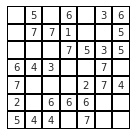

[20 20 20 20 20 20 20]
[20 20 20 20 20 20 20]
[4 4 4 4 4 4 4]
[4 4 4 4 4 4 4]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([21,  1,  2,  3,  4,  5,  6,  7], dtype=int64))


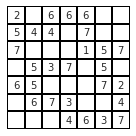

[20 20 20 20 20 20 20]
[20 20 20 20 20 20 20]
[4 4 4 4 4 4 4]
[4 4 4 4 4 4 4]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([21,  1,  2,  3,  4,  5,  6,  7], dtype=int64))


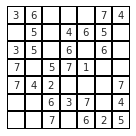

[20 20 20 20 20 20 20]
[20 20 20 20 20 20 20]
[4 4 4 4 4 4 4]
[4 4 4 4 4 4 4]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([21,  1,  2,  3,  4,  5,  6,  7], dtype=int64))


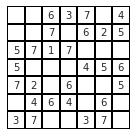

[20 20 20 20 20 20 20]
[20 20 20 20 20 20 20]
[4 4 4 4 4 4 4]
[4 4 4 4 4 4 4]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([21,  1,  2,  3,  4,  5,  6,  7], dtype=int64))


In [8]:
#check the individual grids
sub_print(result[:7,:7])
sub_print(result[5:,:7])
sub_print(result[:7,5:])
sub_print(result[5:,5:])

### Solution as published 
https://www.janestreet.com/puzzles/twenty-four-seven-four-in-one-solution/

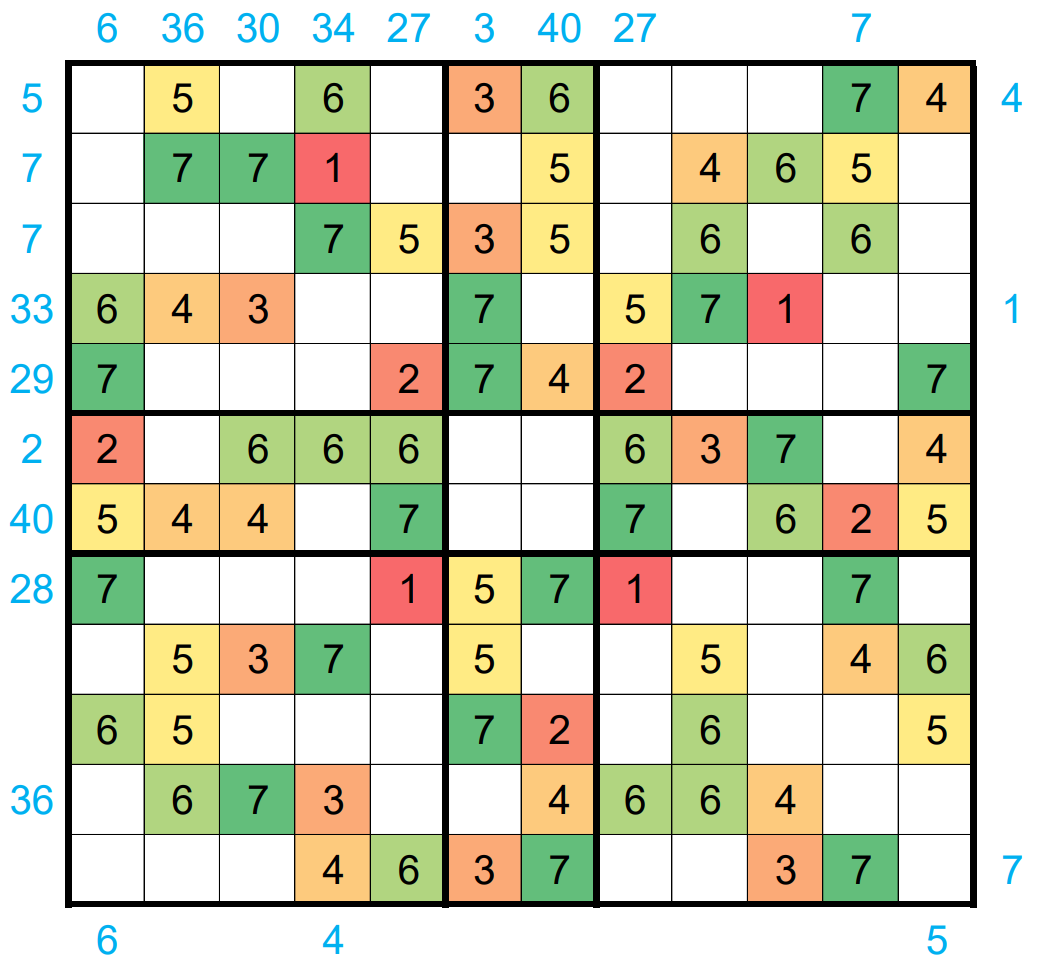

In [9]:
url='https://www.janestreet.com/puzzles/twenty-four-seven-four-in-one-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
tags=soup.findAll('img')
for match in tags:
    match.decompose()

display(Markdown('### Solution as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/twenty-four-seven-four-in-one-solution.png',width=400))
HTML(str(soup.find_all('div', {'class' :'col-12'})[0])+str(soup.find_all('div', {'class' :'col-12'})[4]))